In [3]:
import torch 
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.datasets import Planetoid

from dataset import PyGDatasetLoader
from gcn import GCNConv 
from model import GCNModel
from utils import plot_accuracies, plot_loss, get_node_embeddings, plot_node_embeddings

import matplotlib.pyplot as plt

## For Cora 

In [4]:
#load dataset
loader = PyGDatasetLoader()
dataset, data = loader.load()



Dataset: Cora
Number of graphs: 1
Number of classes: 7

Graph Info:
  Nodes: 2708
  Features per node: 1433
  Edges: 10556
  Train nodes: 140
  Val nodes: 500
  Test nodes: 1000


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNModel(dataset.num_node_features, 32, dataset.num_classes).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


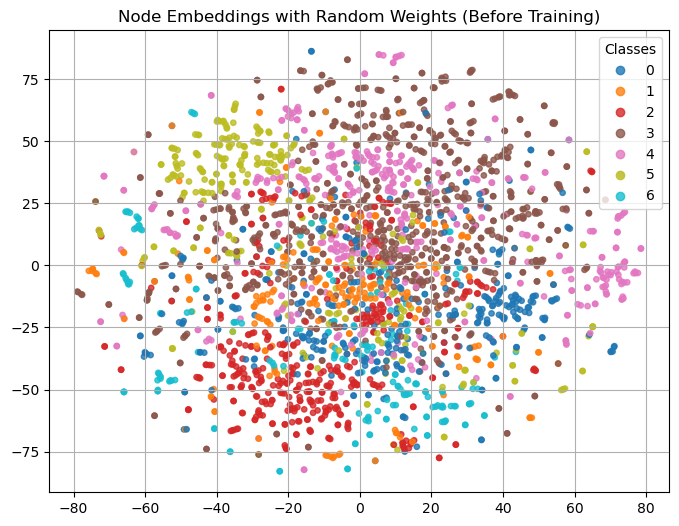

In [7]:
random_emb = get_node_embeddings(model, data, device)
plot_node_embeddings(random_emb, data.y.cpu().numpy(), "Node Embeddings with Random Weights (Before Training)")


In [8]:

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs  

In [9]:
num_epochs = 200
train_losses = []
train_accs = []
val_accs = []
test_accs = []

best_val_acc = 0
best_model_state = None
epochs_without_improvement = 0
patience = 10

for epoch in tqdm(range(1, num_epochs + 1), desc="Training Epochs"):
    loss = train()
    train_acc, val_acc, test_acc = evaluate()

    train_losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    tqdm.write(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if epochs_without_improvement >= patience:
        print(f"\nEarly stopping triggered after {epoch} epochs.")
        break

model.load_state_dict(best_model_state)

model.eval()
train_acc, val_acc, test_acc = evaluate()

print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")
print(f"Test Accuracy at Best Val: {test_acc:.4f}")

Training Epochs:   2%|▏         | 3/200 [00:00<00:07, 26.54it/s]

Epoch 001 | Loss: 1.9526 | Train Acc: 0.4071 | Val Acc: 0.2220
Epoch 002 | Loss: 1.8679 | Train Acc: 0.8571 | Val Acc: 0.5820
Epoch 003 | Loss: 1.7335 | Train Acc: 0.8357 | Val Acc: 0.6340
Epoch 004 | Loss: 1.6157 | Train Acc: 0.8714 | Val Acc: 0.6360


Training Epochs:   5%|▌         | 10/200 [00:00<00:07, 26.04it/s]

Epoch 005 | Loss: 1.4621 | Train Acc: 0.8857 | Val Acc: 0.6620
Epoch 006 | Loss: 1.3323 | Train Acc: 0.9286 | Val Acc: 0.7080
Epoch 007 | Loss: 1.1785 | Train Acc: 0.9500 | Val Acc: 0.7500
Epoch 008 | Loss: 1.0292 | Train Acc: 0.9643 | Val Acc: 0.7580
Epoch 009 | Loss: 0.8617 | Train Acc: 0.9714 | Val Acc: 0.7700
Epoch 010 | Loss: 0.7865 | Train Acc: 0.9786 | Val Acc: 0.7880
Epoch 011 | Loss: 0.6147 | Train Acc: 0.9786 | Val Acc: 0.7980


Training Epochs:   9%|▉         | 18/200 [00:00<00:05, 31.65it/s]

Epoch 012 | Loss: 0.5244 | Train Acc: 0.9786 | Val Acc: 0.7960
Epoch 013 | Loss: 0.4115 | Train Acc: 0.9857 | Val Acc: 0.7820
Epoch 014 | Loss: 0.3471 | Train Acc: 0.9857 | Val Acc: 0.7780
Epoch 015 | Loss: 0.3022 | Train Acc: 0.9857 | Val Acc: 0.7820
Epoch 016 | Loss: 0.2600 | Train Acc: 0.9929 | Val Acc: 0.7800
Epoch 017 | Loss: 0.2059 | Train Acc: 0.9929 | Val Acc: 0.7840
Epoch 018 | Loss: 0.1613 | Train Acc: 1.0000 | Val Acc: 0.7860


Training Epochs:  10%|█         | 20/200 [00:00<00:06, 28.12it/s]

Epoch 019 | Loss: 0.1346 | Train Acc: 1.0000 | Val Acc: 0.7860
Epoch 020 | Loss: 0.1251 | Train Acc: 1.0000 | Val Acc: 0.7780
Epoch 021 | Loss: 0.1034 | Train Acc: 1.0000 | Val Acc: 0.7800

Early stopping triggered after 21 epochs.

Best Validation Accuracy: 0.7980
Test Accuracy at Best Val: 0.8080


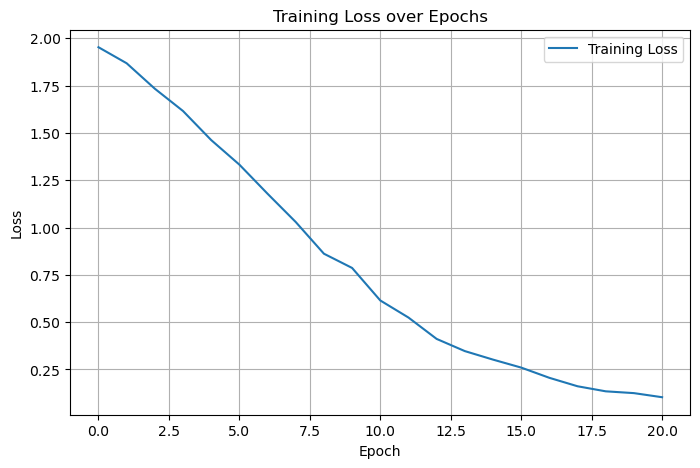

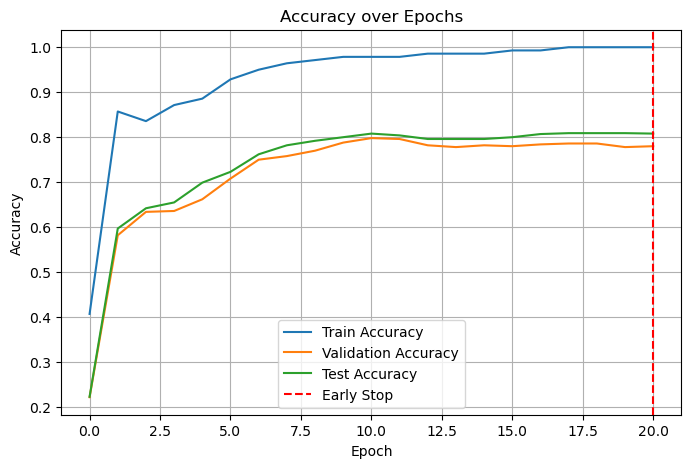

In [10]:
actual_epochs = len(train_losses)

plot_loss(train_losses)
plot_accuracies(train_accs, val_accs, test_accs, early_stop_epoch=actual_epochs)

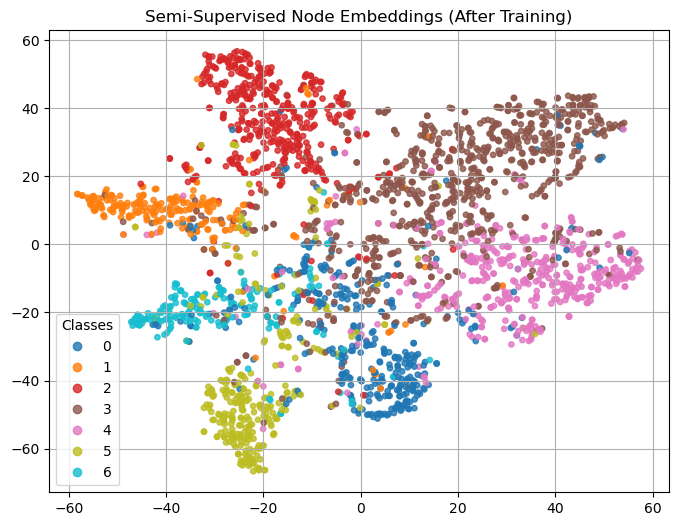

In [11]:
trained_emb = get_node_embeddings(model, data, device)
plot_node_embeddings(trained_emb, data.y.cpu().numpy(), "Semi-Supervised Node Embeddings (After Training)")